In [68]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *
from src.plotter import *
from src.filters import *
import math
import pickle
import pandas as pd
from sklearn.utils import shuffle
import scipy
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tdt 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, hilbert, welch
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy.io import savemat
from scipy.fft import fftshift


from src.neural_analysis import *
from src.wiener_filter import *
from src.filters import *
from src.folder_handler import *
from src.tdt_support import *
from src.decoders import *
from src.plotter import *
from src.phase_decoder_support import *
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from scipy.signal import resample, find_peaks
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import scipy.io as sio
import numpy as np
import pandas as pd
import cv2
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
teq0210 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/teq/0210')
teq0210.process()

read from t=0s to t=356.55s
read from t=0s to t=306.78s


(array([[  0.,  40.,   0., ...,   0.,  20.,  20.],
        [  0.,  60.,  20., ...,   0.,   0.,   0.],
        [  0.,  40.,  20., ...,   0.,   0.,   0.],
        ...,
        [ 60., 120.,  40., ...,  40.,  40.,  20.],
        [ 60.,  40.,   0., ...,  60.,  80.,  40.],
        [  0.,  80.,   0., ...,   0.,  20.,  80.]]),
 array([[ 70.64608109,  97.57468596, 126.03323152, ...,  72.37870212,
          81.30207218, 142.28147997],
        [118.5089405 ,  86.74379613, 116.71256432, ...,  66.460107  ,
          80.5819863 , 149.05987918],
        [ 99.14094375,  75.07944215, 110.50109249, ...,  76.13566963,
          71.49617182, 121.33329213],
        ...,
        [ 78.05304296, 113.44740457, 131.55938192, ...,  75.32258382,
          70.92851616, 131.01520662],
        [ 94.03615309, 105.42869007, 128.71117284, ...,  81.46972809,
          72.96090627, 130.02939816],
        [118.04666246,  82.26442872, 123.14782302, ...,  90.15571071,
          69.69082759, 119.75288105]]),
 array([1., 1., 

In [106]:
#do this before stitch and format is called to ensure no weird behaviors occur at the splice. 
def ss_cleaner(unrect_phase, significant_hesitation):
    phase = np.copy(unrect_phase)
    #first, check for the rare cases where a value of 0 or 1 is sandwiched between two values of 2, 
    #and rectify this to be entirley swing
    for i in range(1,phase.shape[0]-1):
        if (phase[i] == 0) or (phase[i] == 1):
            if (phase[i-1] == 2) and (phase[i+1] == 2):
                phase[i] = 2
    #scrub out any solitary 2's
    # for i in range(1,phase.shape[0]-1):
    #     if (phase[i] == 2) and (phase[i-1] != 2) and (phase[i+1] != 2):
    #         phase[i] = 1
    #next, bias 0 - 1 jittering in favor of 1
    for i in range(1,phase.shape[0]-1):
        if (phase[i] == 0):
            if (phase[i-1] == 1) and (phase[i+1] == 1):
                phase[i] = 1
    #second pass at 0 - 1 jitter
    for i in range(1,phase.shape[0]-1):
        if (phase[i] == 1):
            if (phase[i-1] == 0) and (phase[i+1] == 0):
                phase[i] = 0                 
    #this logic forces the indicies immediately before and after swing to be stance, 
    #which prevents swing phases from running together when 0 becomes null
    for i in range(1,phase.shape[0]-10):
        if (phase[i] == 2) and (phase[i-1] != 2):
            index_list = []
            index_list.append(i)
            tick = 0
            while phase[i+1+tick] == 2:
                index_list.append(i+1+tick)
                tick = tick+1
            if (phase[i-1] != 1):
                phase[i-1] = 1
            if (phase[i+1+tick] != 1):
                phase[i+1+tick] = 1  
    #reject all de-jittered runs of hesitance under some threshold defined in the function call
    for i in range(1,phase.shape[0]-10):
        if (phase[i] == 0) and (phase[i-1] != 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while phase[i+1+tick] == 0:
                index_list.append(i+1+tick)
                tick = tick+1
            if len(index_list) < significant_hesitation:
                if (phase[i-1] == 1) or (phase[i+1+tick] == 1):
                    for j in index_list:
                        phase[j] = 1
                elif (phase[i-1] == 2) and (phase[i+1+tick] == 2):
                    for j in index_list:
                        phase[j] = 2
    return phase

# def swing_angles(phase):
#     swing_array = np.copy(phase)
#     for i in range(swing_array.shape[0]):
#         if swing_array[i] !=2:
#             swing_array[i] = None
#     for i in range(swing_array.shape[0]):
#         if (np.isnan(swing_array[i]) != True) and (np.isnan(swing_array[i-1]) == True):
#             index_list = []
#             index_list.append(i)
#             tick = 0
#             while (np.isnan(swing_array[i+1+tick]) != True):
#                 index_list.append(i+1+tick)
#                 tick = tick+1
#                 if (i+1+tick >= swing_array.shape[0]):
#                     break
#             denom = len(index_list)+1
#             step = 180/denom
#             for j in range(len(index_list)):
#                 angle = step*(j+1)+180
#                 swing_array[index_list[j]] = angle
#         elif (np.isnan(swing_array[i]) != True) and (i == 0):
#             index_list = []
#             index_list.append(i)
#             tick = 0
#             while (np.isnan(swing_array[i+1+tick]) != True):
#                 index_list.append(i+1+tick)
#                 tick = tick+1
#                 if (i+1+tick >= swing_array.shape[0]):
#                     break
#             denom = len(index_list)+1
#             step = 180/denom
#             for j in range(len(index_list)):
#                 angle = step*(j+1)+180
#                 swing_array[index_list[j]] = angle       
#     return swing_array

# def stance_angles(phase):
#     stance_array = np.copy(phase)
#     for i in range(stance_array.shape[0]):
#         if stance_array[i] !=1:
#             stance_array[i] = None
#     for i in range(stance_array.shape[0]):
#         if (np.isnan(stance_array[i]) != True) and (np.isnan(stance_array[i-1]) == True):
#             index_list = []
#             index_list.append(i)
#             tick = 0
#             while (np.isnan(stance_array[i+1+tick]) != True):
#                 index_list.append(i+1+tick)
#                 tick = tick+1
#                 if (i+1+tick >= stance_array.shape[0]):
#                     break
#             denom = len(index_list)+1
#             step = 180/denom
#             for j in range(len(index_list)):
#                 angle = step*(j+1)
#                 stance_array[index_list[j]] = angle
#         elif (np.isnan(stance_array[i]) != True) and (i == 0):
#             index_list = []
#             index_list.append(i)
#             tick = 0
#             while (np.isnan(stance_array[i+1+tick]) != True):
#                 index_list.append(i+1+tick)
#                 tick = tick+1
#                 if (i+1+tick >= stance_array.shape[0]):
#                     break
#             denom = len(index_list)+1
#             step = 180/denom
#             for j in range(len(index_list)):
#                 angle = step*(j+1)
#                 stance_array[index_list[j]] = angle
#     return stance_array

# def recombine(stance_arr, swing_arr):
#     merged = np.copy(stance_arr)
#     for i in range(stance_arr.shape[0]):
#         if (np.isnan(stance_arr[i]) == True) and (np.isnan(swing_arr[i]) != True):
#             merged[i] = swing_arr[i]
#         elif ((np.isnan(stance_arr[i]) == True) and (np.isnan(swing_arr[i]) == True)) or ((np.isnan(stance_arr[i]) != True) and (np.isnan(swing_arr[i]) != True)):
#             raise ValueError('stance/swing array mistmatch')
#     return merged


def get_phase_angles(phase):
    angle_array = np.copy(phase)
    phase_inits = []
    if angle_array[0] == 1:
        phase_inits.append(0)
    else:
        index_list = []
        index_list.append(0)
        tick = 0
        while (angle_array[tick+1] == 2):
            index_list.append(1+tick)
            tick = tick+1
        denom = len(index_list)
        step = 180/denom
        for index in (index_list):
            angle = 180 + step*index
            angle_array[index_list] = angle
    for i in range(angle_array.shape[0]):    
        if angle_array[i-1] !=1 and angle_array[i] ==1 and angle_array[i] ==1 :
            phase_inits.append(i)
    for init in phase_inits:
        angle_array[init] = None
    for i in range(angle_array.shape[0]):
        if (np.isnan(angle_array[i]) == True):
            index_list = []
            index_list.append(i)
            tick = 0
            while (np.isnan(angle_array[i+1+tick]) != True):
                index_list.append(i+1+tick)
                tick = tick+1
                if (i+1+tick >= angle_array.shape[0]):
                    break
            if angle_array[index_list[-1]] == 2:
                denom = len(index_list)
                step = 360/denom
                for i in range(len(index_list)):
                    angle = step*i
                    angle_array[index_list[i]] = angle
            elif angle_array[index_list[-1]] == 1:
                denom = len(index_list)
                step = 180/denom
                for i in range(len(index_list)):
                    angle = step*i
                    angle_array[index_list[i]] = angle     
    return angle_array

# def get_phase_training_data(self, scrubber):
#     rect_phase_list = []
#     for i in range(len(self.data['phase'])):
#         scrub_phase = ss_cleaner(self.data['phase'][i], scrubber)
#         rect_phase_list.append(scrub_phase)
#     form_rates, form_phase = self.stitch_and_format(teq0210.data['rates'], rect_phase_list)
#     phase_12 = form_phase[np.nonzero(form_phase)]
#     rates_12 = form_rates[np.nonzero(form_phase),:][0]






In [113]:
rect_phase_list = []
for i in range(len(teq0210.data['phase'])):
    scrub_phase = ss_cleaner(teq0210.data['phase'][i], 3)
    rect_phase_list.append(scrub_phase)
form_rates, form_phase = teq0210.stitch_and_format(teq0210.data['rates'], rect_phase_list)
phase_12 = form_phase[np.nonzero(form_phase)]
rates_12 = form_rates[np.nonzero(form_phase),:][0]
phase_angles = get_phase_angles(phase_12)
sin_arr, cos_arr = sine_and_cosine(phase_angles)
h_sin, lsq_sin, r2_sin, test_rates, test_sin, sin_test_index = decode_kfolds_single_nonlinear(X=rates_12, Y=sin_arr, scoring='R2')
h_cos, lsq_cos, r2_cos, _, test_cos, _ = decode_kfolds_single_nonlinear(X=rates_12, Y=cos_arr, scoring='R2', forced_test_index = sin_test_index)
predicted_sin = test_nonlinear_wiener_filter(test_rates, h_sin, lsq_sin)
predicted_cos = test_nonlinear_wiener_filter(test_rates, h_cos, lsq_cos)
predicted_arctans = arctan_fn(predicted_sin, predicted_cos)
test_arctans = merged_arr[sin_test_index]

<class 'numpy.ndarray'>


In [96]:
reeee = phase_angles(phase_12)


1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
1.0
1.0


In [80]:
print(rates_12.shape)
print(form_rates.shape)

(9847, 320)
(12575, 320)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
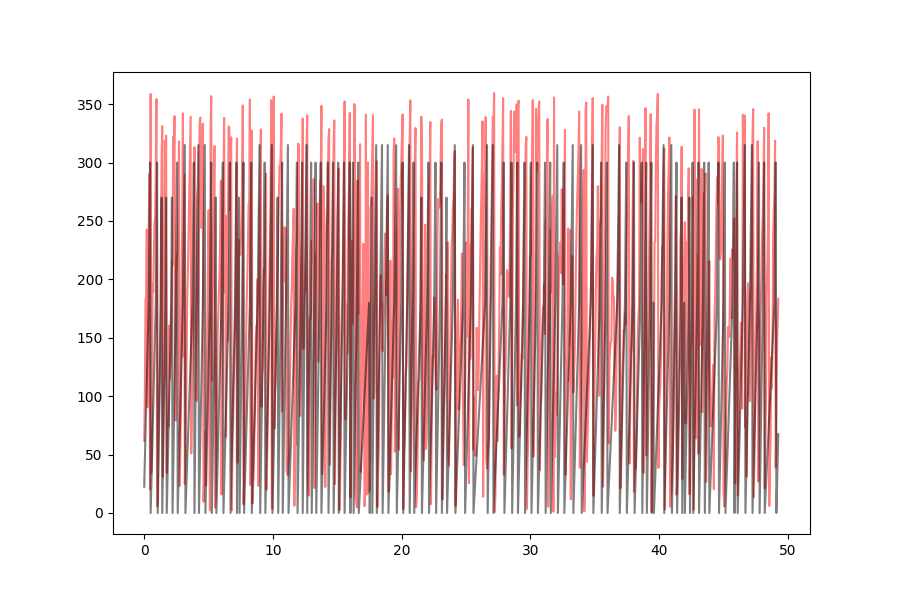

In [123]:
tstest = np.linspace(0, (test_arctans.shape[0]*50)/1000,test_arctans.shape[0])

fig512, ax= plt.subplots(1, 1, figsize=(9,6), sharex = True)
ax.plot(tstest, predicted_arctans, alpha = 0.5, c = 'r' )
ax.plot(tstest, test_arctans, alpha = 0.5, c = 'k' )



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
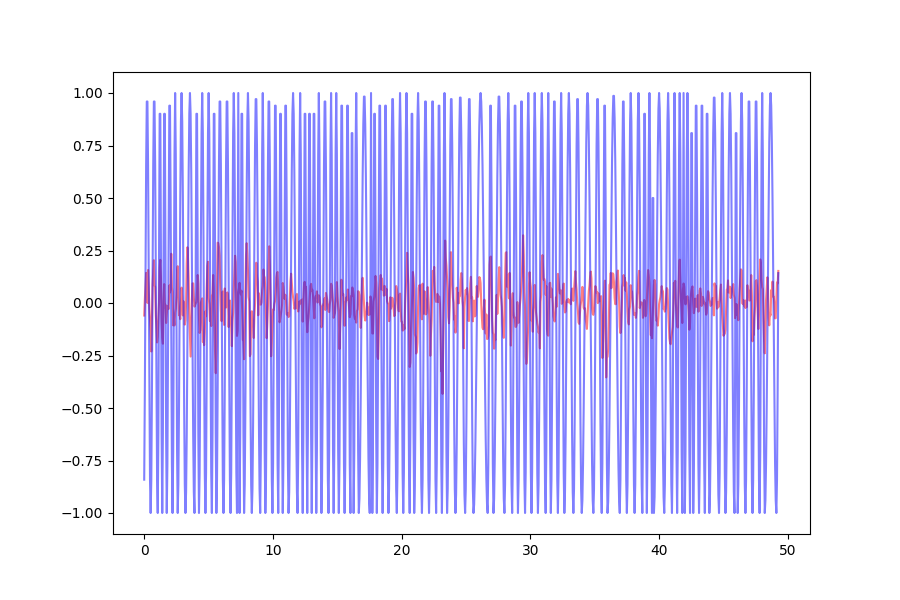

In [116]:
tstest = np.linspace(0, (test_arctans.shape[0]*50)/1000,test_arctans.shape[0])

fig512, ax= plt.subplots(1, 1, figsize=(9,6), sharex = True)
ax.plot(tstest, predicted_cos, alpha = 0.5, c = 'r' )
ax.plot(tstest, test_cos, alpha = 0.5, c = 'b' )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
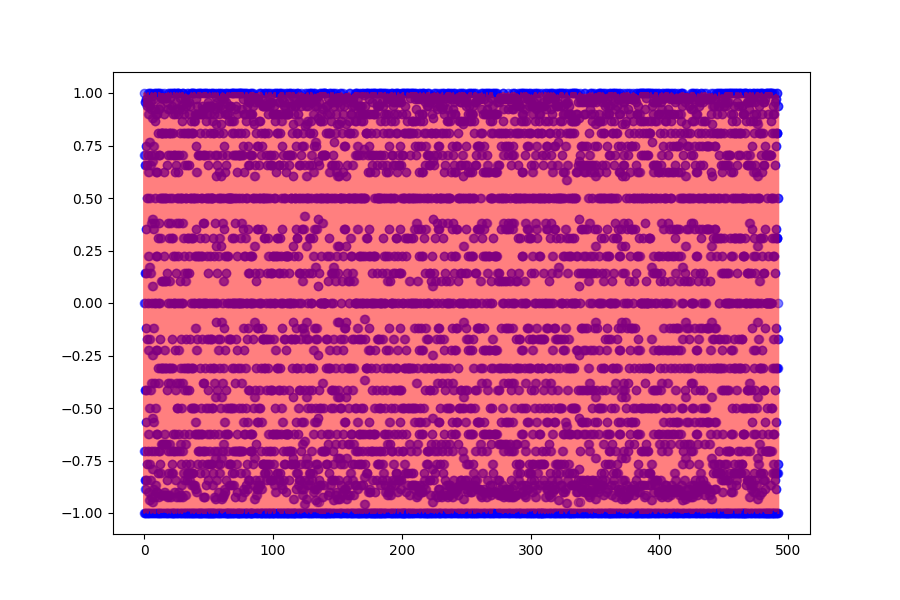

In [112]:
tso = np.linspace(0, (phase_angles.shape[0]*50)/1000,phase_angles.shape[0])

fig512, ax= plt.subplots(1, 1, figsize=(9,6), sharex = True)
ax.plot(tso, sin_arr, alpha = 0.5, c = 'r' )
ax.scatter(tso, cos_arr, alpha = 0.5, c = 'b' )


In [117]:
h_angle, angle_vaf_array, angle_test_x, angle_test_y = teq0210.decode_angles(metric_angle='forelimb')
                  

In [120]:
teq0210.data['angle_names']

['ankle', 'knee', 'hip', 'limbfoot', 'elbow', 'shoulder', 'forelimb']

In [121]:
h_angle.shape

(321, 7)

In [118]:
print(angle_vaf_array)

[-0.031 -0.038  0.006  0.002 -0.013 -0.059 -0.031]


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:title={'center':'vaf:0.05'}>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
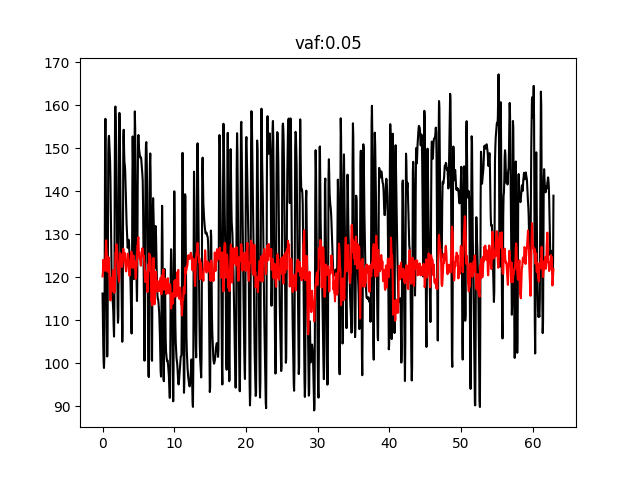

In [122]:
plot_wiener_filter_predic(angle_test_x, angle_test_y[:,-1], h_angle[:,-1])

In [150]:
def replace_with_null(arr, buffer):
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            j = i
            while j < len(arr) and arr[j] == 0:
                j += 1
            if j - i >= buffer:
                for k in range(i, j):
                    arr[k] = None
            i = j
        else:
            i += 1
    return arr

def replace_null(arr):
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]) == True:
            arr[i] = 0
    return arr

def x_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dddk = np.diff(kin_signal, 3)
    dddkdddt_tmp = dddk/(dt**3)
    dddkdddt = lowpass_filt(dddkdddt_tmp, 10, 200)
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    dddkdddt = np.append(dddkdddt, [0,0,0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_peaks, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.sort(kin_signal)[-probable_kink])
    dddkdddt_valleys, _ = spicy.signal.find_peaks(-(dddkdddt), distance= 50, threshold =10,prominence = 5, height = -0.5*np.sort(dddkdddt)[probable_kink])    
    print('dddkdddt_valleys:', len(dddkdddt_valleys))
    bdkdt = np.zeros((dkdt.shape[0]))
    threshold = np.sort(dkdt)[-probable_kink]
    print("swing threshold:", threshold*0.1)

    for i in range(len(dkdt)):
        if (dkdt[i]) >= threshold*0.1:
            bdkdt[i] = 1
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 1:
            if (bdkdt[i+1] == 0) and (bdkdt[i-1] == 0):
                bdkdt[i] = 0
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 0:
            if (bdkdt[i+1] == 1) and (bdkdt[i-1] == 1):
                bdkdt[i] = 1
    for i in range(0,len(bdkdt)-50,1):
        if (bdkdt[i] == 1) and (bdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while bdkdt[i+1+tick] == 1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in kin_peaks for val in index_list) or any(val in dddkdddt_valleys for val in index_list):
                if any(val in kin_peaks for val in index_list) and any(val in dddkdddt_valleys for val in index_list):
                    continue
                else:
                    for index in index_list:
                        bdkdt[index] = 0.5
            else:
                for index in index_list:
                    bdkdt[index] = 0  
    return bdkdt

    
def x_stance_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal,2)
    ddkddt_tmp = ddk/(dt**2)
    ddkddt = lowpass_filt(ddkddt_tmp, 10, 200)
    ddkddt = np.append(ddkddt, [0, 0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -2*np.sort(kin_signal)[probable_kink])    
    ddkddt_peaks, _ = spicy.signal.find_peaks(ddkddt, prominence=3, distance= 50, height = 0.3*np.sort(ddkddt)[-probable_kink])    
    ddkddt_valleys, _ = spicy.signal.find_peaks(-(ddkddt), prominence=3, distance= 50, height = -0.3*np.sort(ddkddt)[probable_kink]) 
    ddkddt_peaks = ddkddt_peaks - 25
    ddkddt_valleys = ddkddt_valleys + 25
    qdkdt = np.zeros((dkdt.shape[0]))
    threshold = np.sort(dkdt)[probable_kink]
    print("stance threshold:", threshold*0.1)
    for i in range(len(dkdt)):
        if (dkdt[i]) <= threshold*0.1:
            qdkdt[i] = -1
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == -1:
            if (qdkdt[i+1] == 0) and (qdkdt[i-1] == 0):
                qdkdt[i] = 0
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == 0:
            if (qdkdt[i+1] == -1) and (qdkdt[i-1] == -1):
                qdkdt[i] = -1
    for i in range(0,len(qdkdt)-50,1):
        if (qdkdt[i] == -1) and (qdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while qdkdt[i+1+tick] == -1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in ddkddt_valleys for val in index_list) or any(val in ddkddt_peaks for val in index_list):
                if any(val in ddkddt_valleys for val in index_list) and any(val in ddkddt_peaks for val in index_list):
                    continue
                else:
                    for index in index_list:
                        qdkdt[index] = -0.5
            else:
                for index in index_list:
                    qdkdt[index] = 0
    return qdkdt

def slow_stance_exceptor(kin_signal, sss):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal,2)
    ddkddt_tmp = ddk/(dt**2)
    ddkddt = lowpass_filt(ddkddt_tmp, 10, 200)
    ddkddt = np.append(ddkddt, [0, 0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -2*np.sort(kin_signal)[probable_kink])    
    ddkddt_peaks, _ = spicy.signal.find_peaks(ddkddt, prominence=3, distance= 50, height = 0.3*np.sort(ddkddt)[-probable_kink])    
    ddkddt_valleys, _ = spicy.signal.find_peaks(-(ddkddt), prominence=3, distance= 50, height = -0.3*np.sort(ddkddt)[probable_kink]) 
    ddkddt_peaks = ddkddt_peaks - 25
    ddkddt_valleys = ddkddt_valleys + 25
    sss_null = replace_with_null(sss, 30)
    for i in range(1,len(sss)-1,1):
        if sss[i] == 0 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss[i-1] in (-0.5, -1) and sss[i+1+tick] in (-0.5, -1):
                for index in index_list:
                    sss[index] = -1
    for i in range(1,len(sss)-1,1):
        if sss[i] == -0.5 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss[i-1] in (-0.5, -1) or sss[i+1+tick] in (-0.5, -1):
                for index in index_list:
                    sss[index] = -1
    for i in range(1,len(sss)-1,1):
        if sss[i] == -1 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in ddkddt_valleys for val in index_list) and any(val in ddkddt_peaks for val in index_list):
                continue
            else:
                for index in index_list:
                    sss[index] = -0.5
    sss = replace_null(sss)
    return sss

def stance_swing_trinary(sss, kin_signal = None, slow_stance_exception = False): 
    if sss is None and kin_signal is not None:
        swing_ind = x_swing_binary(kin_signal)
        stance_ind = x_stance_binary(kin_signal)
        sss = np.sum((swing_ind, stance_ind), axis = 0) 
        if slow_stance_exception == True:
            sss = slow_stance_exceptor(kin_signal, sss)
    
    sss_null = replace_with_null(sss, 30)
    for i in range(10,len(sss_null)-50,1):
        if (sss_null[i] == 0) and (sss_null[i-1] != 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while sss_null[i+1+tick] == 0:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss_null[i-1] is not None and sss_null[i+1+tick] is not None:
                if sss_null[i-1] == sss_null[i+1+tick]:
                    for index in index_list:
                        sss_null[index] = sss_null[i-1]
                elif len(index_list) > 1:
                    if len(index_list) % 2 == 1:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid+1:]:
                            sss_null[index] = sss_null[i+tick+1]
                    elif len(index_list) % 2 == 0:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid:]:
                            sss_null[index] = sss_null[i+tick+1]
    for i in range(1,len(sss_null)-1,1):
        if (sss_null[i] == 0):
            if sss_null[i-1] is not None and sss_null[i+1] is not None:
                if (sss_null[i-1] != 0) and (sss_null[i+1] != 0):
                    if random.random() <= 0.5:
                        sss_null[i] = sss_null[i-1]
                    else:
                        sss_null[i] = sss_null[i+1]
    np.array(sss_null)
    sstrinary = replace_null(sss_null)
    return sstrinary


def scrubber(phase, length):
    adjustments = 0
    for i in range(1,len(phase)-1,1):
        if phase[i] != 0 and phase[i] != phase[i-1] and abs(phase[i]) < 1:
            index_list = []
            index_list.append(i)
            tick = 0
            while phase[i+1+tick] == phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if len(index_list) < length:
                if abs(phase[i-1]-phase[i]) < abs(phase[i+1+tick]-phase[i]):
                    for index in index_list:
                        phase[index] = phase[i-1]
                        adjustments = adjustments+1
                elif abs(phase[i-1]-phase[i]) > abs(phase[i+1+tick]-phase[i]):
                    for index in index_list:
                        phase[index] = phase[i+1+tick]
                        adjustments = adjustments+1              
                elif phase[i-1] == phase[i+1+tick]:
                    for index in index_list:
                        phase[index] = phase[i+1+tick]
                        adjustments = adjustments+1
                elif abs(phase[i-1]-phase[i]) == abs(phase[i+1+tick]-phase[i]):
                    if abs(phase[i-1]) > abs(phase[i+1+tick]):
                        for index in index_list:
                            phase[index] = phase[i-1]
                            adjustments = adjustments+1
                    if abs(phase[i-1]) < abs(phase[i+1+tick]):
                        for index in index_list:
                            phase[index] = phase[i+1+tick]
                            adjustments = adjustments+1
            
    print(adjustments)
    return phase


def forelimb_phaser(slow_stance_exception = False):
    rel_x1 = relative_x_tmp('wrist')
    rel_x2 = relative_x_tmp('knuckle')
    rel_x3 = relative_x_tmp('finger')
    wrist_phase = stance_swing_trinary(sss= None, kin_signal = rel_x1, slow_stance_exception = slow_stance_exception)
    knuckle_phase = stance_swing_trinary(sss= None, kin_signal = rel_x2, slow_stance_exception = slow_stance_exception)
    finger_phase = stance_swing_trinary(sss= None, kin_signal = rel_x3, slow_stance_exception = slow_stance_exception)
    sum_phase = np.sum((wrist_phase, knuckle_phase, finger_phase), axis=0)
    for i in range(1,len(sum_phase)-1,1):
        if sum_phase[i] >= 1.5 and sum_phase[i] < 3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] >= 1.5 or sum_phase[i+1+tick] >= 1.5:
                for index in index_list:
                    sum_phase[index] = 3
        if sum_phase[i] <= -1.5 and sum_phase[i] > -3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 or sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
    for i in range(1,len(sum_phase)-1,1):
        if sum_phase[i] >= 0.5 and sum_phase[i] < 3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] >= 1.5 and sum_phase[i+1+tick] >= 1.5:
                for index in index_list:
                    sum_phase[index] = 3
        if sum_phase[i] <= -0.5 and sum_phase[i] > -3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 and sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
    for i in range(len(sum_phase)):
        if sum_phase[i] < 1.5 and sum_phase[i] > -1.5:
            sum_phase[i] = 0
    sum_phase = sum_phase /3
    sum_phase = stance_swing_trinary(sss = sum_phase)
    sum_phase = scrubber(sum_phase, 10)
    for i in range(1,len(sum_phase)-1,1):
        if abs(sum_phase[i]) < 1 and sum_phase[i] != 0 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] == 0 or sum_phase[i+tick+1] == 0:
                for index in index_list:
                    sum_phase[index] = 0
            elif sum_phase[i] > 0:
                if sum_phase[i-1] < 0 and sum_phase[i+tick+1] < 0:
                    for index in index_list:
                        sum_phase[index] = 1
            elif sum_phase[i] < 0:
                if sum_phase[i-1] > 0 and sum_phase[i+tick+1] > 0:
                    for index in index_list:
                        sum_phase[index] = -1
    sum_phase = scrubber(sum_phase, 500)
    return sum_phase